<a href="https://colab.research.google.com/github/nahbos/AUT-Language-Understanding/blob/main/Proj/farsi_poem_generator_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobhan Moradian Daghigh
Project: NLG - Poem

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
import os
import glob

import numpy as np
import pandas as pd

from tqdm import tqdm

In [3]:
!wget -nc https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Proj/Datasets/train.csv
!wget -nc https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Proj/Datasets/test.csv

File ‘train.csv’ already there; not retrieving.

File ‘test.csv’ already there; not retrieving.



In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [5]:
train.head()

,cat_title,v_order,v_position,poem_text,poet_name,poem_id
0,رباعی,1,0,جز نقش تو در نظر نیامد ما را,حافظ,1
1,رباعی,2,1,جز کوی تو رهگذر نیامد ما را,حافظ,1
2,رباعی,3,0,خواب ارچه خوش آمد همه را در عهدت,حافظ,1
3,رباعی,4,1,حقا که به چشم در نیامد ما را,حافظ,1
4,رباعی,1,0,بر گیر شراب طرب‌انگیز و بیا,حافظ,2


In [6]:
poets = list(train['cat_title'].unique())
poets

['رباعی', 'قطعه', 'قصیده', 'غزل', '<unk>']

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cat_title   8610 non-null   object
 1   v_order     8610 non-null   int64 
 2   v_position  8610 non-null   int64 
 3   poem_text   8610 non-null   object
 4   poet_name   8610 non-null   object
 5   poem_id     8610 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 403.7+ KB


In [8]:
list(train['cat_title']).count('<unk>')

496

In [9]:
import pandas as pd
import numpy as np

from pathlib import Path

import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead
from transformers import AutoTokenizer

from IPython import display

In [10]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
model_name_or_path = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [12]:
texts = train['poem_text'].values.tolist()
max_seq = max([len(tokenizer.encode(text)) for text in texts])

print(f'The longest text is {max_seq} tokens long.')
print('This is for one hemistich!')

The longest text is 20 tokens long.
This is for one hemistich!


In [13]:
max_length = 20 * 2

In [14]:
groups = train.groupby(by='v_position')
hemistichs1, hemistichs2 = [], []
for grp, pdf in groups:
    if grp == 0:
        hemistichs1 = list(pdf['poem_text'])
    else:
        hemistichs2 = list(pdf['poem_text'])

verses = []
for h1, h2 in zip(hemistichs1, hemistichs2):
    verse = h1 + ' <sep> ' + h2
    verses.append(verse)

In [15]:
verses[0]

'جز نقش تو در نظر نیامد ما را <sep> جز کوی تو رهگذر نیامد ما را'

In [16]:
groups = test.groupby(by='v_position')
hemistichs1_test, hemistichs2_test = [], []
for grp, pdf in groups:
    if grp == 0:
        hemistichs1_test = list(pdf['poem_text'])
    else:
        hemistichs2_test = list(pdf['poem_text'])
  
verses_test = []
for h1_test, h2_test in zip(hemistichs1_test, hemistichs2_test):
    verse = h1_test + ' <sep> ' + h2_test
    verses_test.append(verse)

In [18]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [19]:
from datasets import Dataset

In [20]:
train = {"input":verses[:-1], "label":verses[1:]}
dataset_train = Dataset.from_dict(train)

In [21]:
test = {"input":verses_test[:-1], "label":verses_test[1:]}
dataset_test = Dataset.from_dict(test)

In [22]:
from datasets import DatasetDict
datasets = DatasetDict({"train":dataset_train, "test":dataset_test})

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=False)


def setup(verses):
    input_list = verses['input']
    label_list = verses['label']
    
    model_inputs = tokenizer(input_list, 
                             max_length=max_length, 
                             padding="max_length", 
                             truncation=True)

    labels = tokenizer(label_list,
                       max_length=max_length, 
                       padding="max_length", 
                       truncation=True).input_ids

    labels_with_ignore_index = []
    for labels_example in labels:
      labels_example = [label if label != 0 else -100 for label in labels_example]
      labels_with_ignore_index.append(labels_example)
    
    model_inputs["labels"] = labels_with_ignore_index

    return model_inputs

In [24]:
dataset = datasets.map(setup, batched=True, remove_columns=datasets["train"].column_names)

Map:   0%|          | 0/4304 [00:00<?, ? examples/s]

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

In [25]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch

dataset.set_format(type="torch", 
                   columns=['input_ids', 'attention_mask', 'labels'])

train_dataset, val_dataset = random_split(dataset["train"], [0.9, 0.1], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=18)
val_dataloader = DataLoader(val_dataset, batch_size=18)
test_dataloader = DataLoader(dataset['test'], batch_size=18)

f'There are {len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

'There are 3874 samples for training, and 430 samples for validation testing'

In [26]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 24.3 MB/s eta 0:00:00


In [27]:
from transformers import MT5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl

class PoemMT5(pl.LightningModule):
    def __init__(self, lr=5e-5, num_train_epochs=15, warmup_steps=1000):
        super().__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained(model_name_or_path)
        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask, labels=None):     
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs
    
    def common_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss
        return loss
      
    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)     
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        num_train_optimization_steps = self.hparams.num_train_epochs * len(train_dataloader)
        lr_scheduler = {'scheduler': get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.hparams.warmup_steps,
                                                    num_training_steps=num_train_optimization_steps),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}
        
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

In [28]:
model = PoemMT5()

In [29]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = Trainer(default_root_dir="/content/Checkpoints",
                  callbacks=[early_stop_callback, lr_monitor])
trainer.fit(model)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


MisconfigurationException: ignored

In [98]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    bos_token_id=tokenizer.encode('<bos>')[0],
    eos_token_id=tokenizer.encode('<eos>')[0],
    pad_token_id=tokenizer.encode('<pad>')[0],
    unk_token_id=tokenizer.encode('<unk>')[0],
    vers_token_id=tokenizer.encode('<vers>')[0],
    )

In [ ]:
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /content/gpt2/
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/config.json" -P /content/gpt2/

--2023-02-24 10:47:40--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 54.235.118.239, 3.231.67.228, 2600:1f18:147f:e850:e203:c458:10cd:fc3c, ...
Connecting to huggingface.co (huggingface.co)|54.235.118.239|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/HooshvareLab/gpt2-fa/46b0b806c740a0f0a9f056f5574c5fa896166fe844945fd3c849bf34365e5060?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1677494861&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL0hvb3NodmFyZUxhYi9ncHQyLWZhLzQ2YjBiODA2Yzc0MGEwZjBhOWYwNTZmNTU3NGM1ZmE4OTYxNjZmZTg0NDk0NWZkM2M4NDliZjM0MzY1ZTUwNjA%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT1hcHBsaWNhdGlvbiUyRm9jdGV0LXN0cmVhbSIsIkNvbmRpdGlvbiI6eyJEY

In [ ]:
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/config.json" -P /content/gpt2/

--2023-02-24 10:47:51--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/config.json
Resolving huggingface.co (huggingface.co)... 54.235.118.239, 3.231.67.228, 2600:1f18:147f:e850:e203:c458:10cd:fc3c, ...
Connecting to huggingface.co (huggingface.co)|54.235.118.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 808 [text/plain]
Saving to: ‘/content/gpt2/config.json.5’

config.json.5       100%[===================>]     808  --.-KB/s    in 0s      

2023-02-24 10:47:51 (182 MB/s) - ‘/content/gpt2/config.json.5’ saved [808/808]



In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('./gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("./gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
epochs = 15
warmup_steps = 1e2
sample_every = 100

In [ ]:
from transformers import AdamW

# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters.
optimizer = AdamW(
    model.parameters(),
    lr=5e-3,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)

In [ ]:
sample_verse = verses[np.random.randint(0, len(verses))]
sample_input = f"{sample_verse}<|startoftext|>"
print(sample_input)
sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
sample_input_ids = sample_input_ids.to(device)

sample_outputs = model.generate(
    input_ids=sample_input_ids,
    do_sample=True,
    top_k=50,
    max_length=max_seq,
    top_p=0.95,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id

)
gen_sample_output = tokenizer.decode(sample_outputs[0], skip_special_tokens=False)

print(f'Example output: {gen_sample_output.split("<|startoftext|>")[-1]}')

ای نسیم سحر آرامگه یار کجاست <sep> منزل آن مه عاشق کش عیار کجاست<|startoftext|>
Example output:  خانه او زشته و زشته است؟ و چه طور که


In [ ]:
import random
import time
import datetime
from tqdm import tqdm


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print()
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_verse = verses[np.random.randint(0, len(verses))]
            sample_input = f"{sample_verse}<|startoftext|>"
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                do_sample=True,
                top_k=50,
                max_length=max_seq,
                top_p=0.95,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
            
            for i, output in enumerate(sample_outputs):
                o = tokenizer.decode(output, skip_special_tokens=False)
                o = o.replace("<|startoftext|>", "\n")

            print()
            print(f'Example output: {o}')

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print()
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

  0%|          | 0/15 [00:00<?, ?it/s]

Beginning epoch 1 of 15


 47%|████▋     | 101/216 [00:17<00:23,  4.93it/s]


Batch 100 of 216. Loss:5.608980655670166. Time:0:00:18

Example output: کافر مبیناد این غم که دیده‌ست <sep> از قامتت سرو از عارضت ماه
 هاتالم را هر دو و می‌زند


 93%|█████████▎| 200/216 [00:35<00:02,  5.58it/s]


Batch 200 of 216. Loss:5.225040435791016. Time:0:00:36

Example output: غبار راه طلب کیمیای بهروزیست <sep> غلام دولت آن خاک عنبرین بویم
 از این مرحله ز من می‌خورد به کار می


100%|██████████| 216/216 [00:38<00:00,  5.62it/s]



Average Training Loss: 5.557233507986422. Epoch time: 0:00:38



  7%|▋         | 1/15 [00:39<09:14, 39.64s/it]


Validation loss: 5.254396438598633. Validation Time: 0:00:01

Beginning epoch 2 of 15


 46%|████▋     | 100/216 [00:17<00:20,  5.76it/s]


Batch 100 of 216. Loss:4.919280529022217. Time:0:00:18


 47%|████▋     | 101/216 [00:17<00:31,  3.69it/s]


Example output: حافظا خلد برین خانه موروث من است <sep> اندر این منزل ویرانه نشیمن چه کنم
 پیر میخانه می‌آید و هم یار می و


 93%|█████████▎| 200/216 [00:35<00:02,  5.78it/s]


Batch 200 of 216. Loss:4.753548622131348. Time:0:00:35

Example output: آنکه روشن بد جهان‌بینش بدو <sep> میل در چشم جهان‌بینش کشید
 <sep> ز مشرق در این دیرانه که زیر در


100%|██████████| 216/216 [00:37<00:00,  5.69it/s]



Average Training Loss: 4.805111269156138. Epoch time: 0:00:38



 13%|█▎        | 2/15 [01:18<08:31, 39.33s/it]


Validation loss: 4.964952230453491. Validation Time: 0:00:01

Beginning epoch 3 of 15


 47%|████▋     | 101/216 [00:17<00:22,  5.11it/s]


Batch 100 of 216. Loss:4.291557788848877. Time:0:00:17

Example output: گر رنج پیش آید و گر راحت ای حکیم <sep> نسبت مکن به غیر که این‌ها خدا کند
 <sep> باده فروش و زرق 


 93%|█████████▎| 201/216 [00:35<00:02,  5.01it/s]


Batch 200 of 216. Loss:4.351637363433838. Time:0:00:35

Example output: دل دادمش به مژده و خجلت همی‌برم <sep> زین نقد قلب خویش که کردم نثار دوست
 حافظ <sep> برو آن جام که حافظ


100%|██████████| 216/216 [00:37<00:00,  5.74it/s]



Average Training Loss: 4.36930223857915. Epoch time: 0:00:38



 20%|██        | 3/15 [01:57<07:49, 39.12s/it]


Validation loss: 4.9623411893844604. Validation Time: 0:00:01

Beginning epoch 4 of 15


 47%|████▋     | 101/216 [00:17<00:22,  5.13it/s]


Batch 100 of 216. Loss:3.9466211795806885. Time:0:00:18

Example output: کیست حافظ تا ننوشد باده بی آواز رود <sep> عاشق مسکین چرا چندین تجمل بایدش
 <sep> گر میلم گر چه


 93%|█████████▎| 200/216 [00:34<00:02,  5.74it/s]


Batch 200 of 216. Loss:4.389760494232178. Time:0:00:35

Example output: ببرد از من قرار و طاقت و هوش <sep> بت سنگین دل سیمین بناگوش
 <sep> دوش می‌گفت حدیث و بعد از این ناله


100%|██████████| 216/216 [00:37<00:00,  5.71it/s]



Average Training Loss: 4.091221506948824. Epoch time: 0:00:38



 27%|██▋       | 4/15 [02:36<07:09, 39.07s/it]


Validation loss: 5.018785456816356. Validation Time: 0:00:01

Beginning epoch 5 of 15


 47%|████▋     | 101/216 [00:17<00:23,  4.93it/s]


Batch 100 of 216. Loss:4.078007698059082. Time:0:00:17

Example output: سر ما فرونیاید به کمان ابروی کس <sep> که درون گوشه گیران ز جهان فراغ دارد
 <sep> هزار غم عشق <sep> دوش شد جان


 93%|█████████▎| 200/216 [00:34<00:02,  5.78it/s]


Batch 200 of 216. Loss:4.515117168426514. Time:0:00:35

Example output: این نقطه سیاه که آمد مدار نور <sep> عکسیست در حدیقه بینش ز خال تو
 بود حافظ اگر و در این قصه‌ات راه قدم


100%|██████████| 216/216 [00:37<00:00,  5.73it/s]



Average Training Loss: 4.053429312176174. Epoch time: 0:00:38



 33%|███▎      | 5/15 [03:15<06:30, 39.01s/it]


Validation loss: 5.12553733587265. Validation Time: 0:00:01

Beginning epoch 6 of 15


 46%|████▋     | 100/216 [00:17<00:20,  5.77it/s]


Batch 100 of 216. Loss:3.985280990600586. Time:0:00:17

Example output: مغنی کجایی به گلبانگ رود <sep> به یاد آور آن خسروانی سرود
 <sep> تا چه خواهد <sep> یار که لطف در همه بی‌


 93%|█████████▎| 201/216 [00:35<00:02,  5.16it/s]


Batch 200 of 216. Loss:4.554901123046875. Time:0:00:35

Example output: حافظ به زیر خرقه قدح تا به کی کشی <sep> در بزم خواجه پرده ز کارت برافکنم
 <sep> هر دم کز سر کوی


100%|██████████| 216/216 [00:37<00:00,  5.72it/s]



Average Training Loss: 4.279987497462167. Epoch time: 0:00:38



 40%|████      | 6/15 [03:54<05:50, 38.99s/it]


Validation loss: 5.396650513013204. Validation Time: 0:00:01

Beginning epoch 7 of 15


 47%|████▋     | 101/216 [00:17<00:22,  5.00it/s]


Batch 100 of 216. Loss:4.91845178604126. Time:0:00:18

Example output: حافظ از باد خزان در چمن دهر مرنج <sep> فکر معقول بفرما گل بی خار کجاست
 <sep> زین جا که تاج تو بر صبا


 93%|█████████▎| 201/216 [00:35<00:03,  4.96it/s]


Batch 200 of 216. Loss:4.677859783172607. Time:0:00:35

Example output: از دست رفته بود وجود ضعیف من <sep> صبحم به بوی وصل تو جان بازداد باد
 افتاد <sep> گر نه روز از آن ساعت 


100%|██████████| 216/216 [00:37<00:00,  5.73it/s]



Average Training Loss: 4.617529449639497. Epoch time: 0:00:38



 47%|████▋     | 7/15 [04:33<05:11, 38.95s/it]


Validation loss: 5.404122432072957. Validation Time: 0:00:01

Beginning epoch 8 of 15


 47%|████▋     | 101/216 [00:17<00:23,  4.97it/s]


Batch 100 of 216. Loss:4.796130657196045. Time:0:00:17

Example output: فلک چو دید سرم را اسیر چنبر عشق <sep> ببست گردن صبرم به ریسمان فراق
 <sep> ز زلف دل حافظ گر تو و


 93%|█████████▎| 201/216 [00:35<00:02,  5.08it/s]


Batch 200 of 216. Loss:4.866150856018066. Time:0:00:35

Example output: بنمای رخ که خلقی واله شوند و حیران <sep> بگشای لب که فریاد از مرد و زن برآید
 <sep> به کمان ابرو و آینه 


100%|██████████| 216/216 [00:37<00:00,  5.75it/s]



Average Training Loss: 4.64775366253323. Epoch time: 0:00:38



 53%|█████▎    | 8/15 [05:12<04:32, 38.88s/it]


Validation loss: 5.508448561032613. Validation Time: 0:00:01

Beginning epoch 9 of 15


 46%|████▋     | 100/216 [00:17<00:20,  5.68it/s]


Batch 100 of 216. Loss:4.835303783416748. Time:0:00:17


 47%|████▋     | 101/216 [00:17<00:29,  3.87it/s]


Example output: من از بازوی خود دارم بسی شکر <sep> که زور مردم آزاری ندارم
دم <sep> چون نشود <sep> بر چشم چشم<sep> که خر


 93%|█████████▎| 200/216 [00:34<00:02,  5.79it/s]


Batch 200 of 216. Loss:5.074038982391357. Time:0:00:35

Example output: بار غمی که خاطر ما خسته کرده بود <sep> عیسی دمی خدا بفرستاد و برگرفت
 می <sep> چو حافظ حافظ نزد و مخمور


100%|██████████| 216/216 [00:37<00:00,  5.72it/s]



Average Training Loss: 4.855203880204095. Epoch time: 0:00:38



 60%|██████    | 9/15 [05:50<03:53, 38.88s/it]


Validation loss: 5.63579938809077. Validation Time: 0:00:01

Beginning epoch 10 of 15


 47%|████▋     | 101/216 [00:17<00:22,  5.01it/s]


Batch 100 of 216. Loss:4.884637355804443. Time:0:00:18

Example output: می خور که شیخ و حافظ و مفتی و محتسب <sep> چون نیک بنگری همه تزویر می‌کنند
 به میخانه برفت <sep>


 93%|█████████▎| 201/216 [00:35<00:02,  5.22it/s]


Batch 200 of 216. Loss:4.79445743560791. Time:0:00:35

Example output: در سه سال آنچه بیندوختم از شاه و وزیر <sep> همه بربود به یک دم فلک چوگانی
 به رندی و <sep> چه


100%|██████████| 216/216 [00:37<00:00,  5.74it/s]



Average Training Loss: 4.703036469441873. Epoch time: 0:00:38



 67%|██████▋   | 10/15 [06:29<03:14, 38.85s/it]


Validation loss: 5.589175800482432. Validation Time: 0:00:01

Beginning epoch 11 of 15


 46%|████▋     | 100/216 [00:17<00:20,  5.76it/s]


Batch 100 of 216. Loss:4.803709030151367. Time:0:00:17

Example output: اگر چه در طلبت همعنان باد شمالم <sep> به گرد سرو خرامان قامتت نرسیدم
 و می‌ارزد <sep> به


 93%|█████████▎| 201/216 [00:34<00:02,  5.40it/s]


Batch 200 of 216. Loss:4.9188127517700195. Time:0:00:35

Example output: مگر دیوانه خواهم شد در این سودا که شب تا روز <sep> سخن با ماه می‌گویم پری در خواب می‌بینم
 <sep> حافظ از


100%|██████████| 216/216 [00:37<00:00,  5.77it/s]



Average Training Loss: 4.823344491146229. Epoch time: 0:00:37



 73%|███████▎  | 11/15 [07:08<02:35, 38.77s/it]


Validation loss: 5.677777489026387. Validation Time: 0:00:01

Beginning epoch 12 of 15


 47%|████▋     | 101/216 [00:17<00:22,  5.09it/s]


Batch 100 of 216. Loss:5.097753047943115. Time:0:00:17

Example output: کشته غمزه خود را به زیارت دریاب <sep> زان که بیچاره همان دل‌نگران است که بود
 <sep> باشد <sep> به خاک دارد


 93%|█████████▎| 200/216 [00:34<00:02,  5.74it/s]


Batch 200 of 216. Loss:4.579487323760986. Time:0:00:35

Example output: روشنی طلعت تو ماه ندارد <sep> پیش تو گل رونق گیاه ندارد
 و ماه <sep> چون حافظ <sep> ماه <sep> ز حد سبز و


100%|██████████| 216/216 [00:37<00:00,  5.76it/s]



Average Training Loss: 4.715651384106389. Epoch time: 0:00:38



 80%|████████  | 12/15 [07:46<01:56, 38.74s/it]


Validation loss: 5.548156142234802. Validation Time: 0:00:01

Beginning epoch 13 of 15


 46%|████▋     | 100/216 [00:17<00:20,  5.78it/s]


Batch 100 of 216. Loss:4.3267741203308105. Time:0:00:17

Example output: کسی گیرد خطا بر نظم حافظ <sep> که هیچش لطف در گوهر نباشد
 پنهانی <sep> به روی چنین نثار خویشتن چیست منزل ماوندی دراز 


 93%|█████████▎| 200/216 [00:35<00:03,  4.88it/s]


Batch 200 of 216. Loss:4.470240592956543. Time:0:00:36


 93%|█████████▎| 201/216 [00:36<00:05,  2.72it/s]


Example output: درج محبت بر مهر خود نیست <sep> یا رب مبادا کام رقیبان
م <sep> دل حافظ ز شاخ <sep> گر از پرتو طلبدبت


100%|██████████| 216/216 [00:38<00:00,  5.54it/s]



Average Training Loss: 4.377722203731537. Epoch time: 0:00:39



 87%|████████▋ | 13/15 [08:27<01:18, 39.20s/it]


Validation loss: 5.482426702976227. Validation Time: 0:00:01

Beginning epoch 14 of 15


 47%|████▋     | 101/216 [00:17<00:22,  5.03it/s]


Batch 100 of 216. Loss:4.271710395812988. Time:0:00:17

Example output: گوی خوبی بردی از خوبان خلخ شاد باش <sep> جام کیخسرو طلب کافراسیاب انداختی
 <sep> ساقی گر مدد دهد وقت شناسان باقی


 93%|█████████▎| 200/216 [00:34<00:02,  5.74it/s]


Batch 200 of 216. Loss:4.15535831451416. Time:0:00:35

Example output: صد بار بگفتی که دهم زان دهنت کام <sep> چون سوسن آزاده چرا جمله زبانی
 چه به بوی<sep> دلا به شوق تو در طلبت


100%|██████████| 216/216 [00:37<00:00,  5.75it/s]



Average Training Loss: 4.157372028739364. Epoch time: 0:00:38



 93%|█████████▎| 14/15 [09:05<00:39, 39.06s/it]


Validation loss: 5.522306720415751. Validation Time: 0:00:01

Beginning epoch 15 of 15


 47%|████▋     | 101/216 [00:17<00:22,  5.06it/s]


Batch 100 of 216. Loss:4.062844276428223. Time:0:00:17

Example output: جریده رو که گذرگاه عافیت تنگ است <sep> پیاله گیر که عمر عزیز بی‌بدل است
 و بهارخبری بود <sep> کس از


 93%|█████████▎| 200/216 [00:34<00:02,  5.75it/s]


Batch 200 of 216. Loss:4.108630180358887. Time:0:00:35

Example output: شعر خونبار من ای باد بدان یار رسان <sep> که ز مژگان سیه بر رگ جان زد نیشم
 <sep> با سر منش را آن مور


100%|██████████| 216/216 [00:37<00:00,  5.76it/s]



Average Training Loss: 3.9949150582154593. Epoch time: 0:00:38



100%|██████████| 15/15 [09:44<00:00, 38.98s/it]


Validation loss: 5.537891268730164. Validation Time: 0:00:01

Total training took 0:09:45


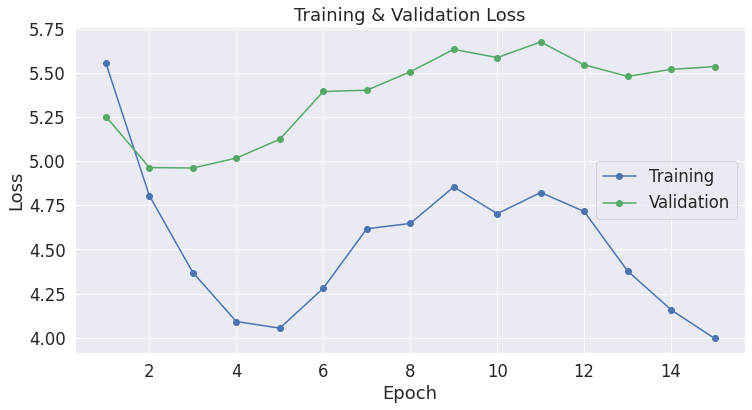

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def generator(sample_verse, max_length=128, num_return_sequences=3, verbose=0):
    model.eval()
    prompt = f"{sample_verse}<|startoftext|>"

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length, 
        top_p=0.95,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id
    )

    for i, output in enumerate(decoded_outputs):
        o = tokenizer.decode(output, skip_special_tokens=False)
        out = o.replace("<|startoftext|>", "\n")
        verse2 = o.split("<|startoftext|>")[-1]
        if verbose == 0:
            print(out)

    return verse2

In [ ]:
sample_v1 = verses[0]
_ = generator(sample_v1, max_length=max_seq, num_return_sequences=1)

جز نقش تو در نظر نیامد ما را <sep> جز کوی تو رهگذر نیامد ما را
 <sep> این آینه جانان نهادم چه حسن و هم


In [ ]:
for _ in range(10):
    _ = generator(verses[100], max_length=max_seq, num_return_sequences=1)

به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 <sep> منعم بر دولت <sep> به سیلی‌ی
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 <sep> لاجرم توست <sep> به بالین دل حافظ سپرد خویشتن
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 <sep> بیا <sep> دولت‌ای مست به تماشاگه
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 و داد <sep> چو شمع در گدایی می‌طلبد خاطرم
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 <sep> که زد <sep> که شاهان اورنگ جم دلم در
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 گدا نما <sep> به تخت ملک در مصطبه جلوهت
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 امر <sep> بر باد آن که دایم می‌طلبد 
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 از جهان عیدی <sep> که به شمشیر ما کردند <sep>
به عهد سلطنت شاه شیخ ابواسحاق <sep> به پنج شخص عجب ملک فارس بود آباد
 <sep> تاصفی و گدا و گدا داند که را ب

In [ ]:
for _ in range(10):
    _ = generator(verses[35], max_length=max_seq, num_return_sequences=1)

نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
و و کنارسار تو تو <sep> که بر دردکشان
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
گان <sep> تا به خاک رهنش که از او
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
 <sep> از پی <sep> حافظ ار بر می‌آورد
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
 <sep> تا که بر فلک می‌تابم <sep>
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
و نباشد <sep> دوش چو جام در حجاز و دلکش 
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
 <sep> آن چه حالت تو <sep> هر تو به گوش
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
وی <sep> به کام دوست ما را <sep> از خر
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
 <sep> ز تاب <sep> بیا که تو ما گذری افت
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآورد به زر
 <sep> اگر ز دست مده به گیس دراز تو به دستم
نرگس که کله دار جهان است ببین <sep> کاو نیز چگونه سر درآو

### Evaluate

In [ ]:
groups = test.groupby(by='v_position')
hemistichs1_test, hemistichs2_test = [], []
for grp, pdf in groups:
    if grp == 0:
        hemistichs1_test = list(pdf['poem_text'])
    else:
        hemistichs2_test = list(pdf['poem_text'])
  
verses_test = []
for h1_test, h2_test in zip(hemistichs1_test, hemistichs2_test):
    verse = h1_test + ' <sep> ' + h2_test
    verses_test.append(verse)

In [ ]:
for _ in range(10):
    generator(verses_test[2], max_length=max_seq, num_return_sequences=1)

ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
ان از بخت جان <sep> ساقی دل تنگ دل افروز واقعه‌ها
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
 می‌<sep> مگر خونبارم <sep> ساقیا ده باده که
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
 و در من آر <sep> به فریاد عشق و غصه اهل ریا نمی‌
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
 سخنس<sep> آن شاه به زیر که در ما <sep> چو قلم 
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
 احترالت ما شاد <sep> هزار تو را غم چون تویی نسیم زند با
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
 سخنو<sep> چون چون تیغ در جان کاسته‌سرا و سایه می‌
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
 و نظر ما آخور ما در نفاق <sep> اگر چو تو شد زمزمه
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
‌ها جان در این <sep> چه شیرینانه را که خطر فضل و
ای کاش که بخت سازگاری کردی <sep> با جور زمانه یار یاری کردی
 زبان چو زلف نگار من‌ی حافظ چو میرمت <sep> جان پریشان
ای کا

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def cal_bleu(reference, candidate):
    reference = [reference.split()]
    candidate = candidate.split()
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    return score

In [ ]:
scores = []
outputs = []
for i in range(len(verses_test) - 1):
    output = generator(verses_test[i], max_length=max_seq, num_return_sequences=1, verbose=1)
    outputs.append(output)
    score = cal_bleu(reference=verses_test[i+1], candidate=output)
    scores.append(score)
  
round(np.average(scores), 3)

Input length of input_ids is 30, but `max_length` is set to 30. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 30, but `max_length` is set to 30. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 30, but `max_length` is set to 30. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


0.065

In [ ]:
ind = np.argmax(scores)
verses_test[ind], verses_test[ind + 1], outputs[ind]

('گر این نصیحت شاهانه بشنوی حافظ <sep> به شاهراه حقیقت گذر توانی کرد',
 'چه مستیست ندانم که رو به ما آورد <sep> که بود ساقی و این باده از کجا آورد',
 ' به تخمین نکنیم این و دینستم <sep> ساقی بیا که جام بر')

Finitoo